In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install higher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets,transforms
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import time
import copy
import torch.nn.functional as F
import copy
from torch import autograd
import higher
import itertools
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [14]:
# Defining the network (LeNet-5)  
class LeNet5(torch.nn.Module):          
    def __init__(self):     
        super(LeNet5, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given as input. Hence padding of 2 is done below)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2) 
        self.fc1 = torch.nn.Linear(16*5*5, 120)   
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = self.max_pool_1(x) 
        x = F.relu(self.conv2(x))
        x = self.max_pool_2(x)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x).squeeze()
        return x

In [15]:
def get_loss_n_accuracy(model, criterion, data_loader, args, num_classes=2):
    """ Returns the loss and total accuracy, per class accuracy on the supplied data loader """
    
    criterion.reduction = 'mean'
    model.eval()                                     
    total_loss, correctly_labeled_samples = 0, 0
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    # forward-pass to get loss and predictions of the current batch
    for _, (inputs, labels) in enumerate(data_loader):
        inputs, labels = inputs.to(device=args['device'], non_blocking=True),\
                labels.to(device=args['device'], non_blocking=True)
                                            
        # compute the total loss over minibatch
        outputs = model(inputs)
        avg_minibatch_loss = criterion(outputs, labels.type_as(outputs))
        total_loss += avg_minibatch_loss.item()*outputs.shape[0]
                        
        # get num of correctly predicted inputs in the current batch
        pred_labels = (F.sigmoid(outputs) > 0.5).int()
        correctly_labeled_samples += torch.sum(torch.eq(pred_labels.view(-1), labels)).item()
        # fill confusion_matrix
        for t, p in zip(labels.view(-1), pred_labels.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
                                
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correctly_labeled_samples / len(data_loader.dataset)
    per_class_accuracy = confusion_matrix.diag() / confusion_matrix.sum(1)
    return avg_loss, (accuracy, per_class_accuracy)

In [28]:
def get_imbalanced_datasets(train_dataset, test_dataset, imbalance=0.5, train_size=5000, meta_size=10):
    # returns an imbalanced mnist dataset of 9 and 4s where imbalance favors 9s
    
    # a balanced test dataset
    test_9_idxs = test_dataset.targets == 9
    test_4_idxs = test_dataset.targets == 4
    test_9_data = test_dataset.data[test_9_idxs][:982]
    test_4_data = test_dataset.data[test_4_idxs][:982] # num of 4 samples 
    test_data = torch.cat((test_9_data, test_4_data))
    test_targets = torch.cat( (torch.ones(len(test_9_data))*1, torch.ones(len(test_4_data))*0 ) )
    test_dataset.data = test_data
    test_dataset.targets = test_targets
    
    # imbalanced training dataset
    n_9s = int(train_size * imbalance)
    n_4s = train_size - n_9s
    train_9_idxs = train_dataset.targets == 9
    train_4_idxs = train_dataset.targets == 4 
    train_9_data = train_dataset.data[train_9_idxs][:n_9s]
    train_4_data = train_dataset.data[train_4_idxs][:n_4s]
    train_data = torch.cat((train_9_data, train_4_data))
    train_targets = torch.cat( (torch.ones(len(train_9_data))*1, torch.ones(len(train_4_data))*0 ) )
    train_dataset.data = train_data
    train_dataset.targets = train_targets
    
    # a balanced meta dataset for weighting samples (which is subset of training dataset)
    # note that we have relabed 9s as 1 and 4s as 0
    meta_dataset = copy.deepcopy(train_dataset)
    meta_9_idxs = meta_dataset.targets == 1
    meta_4_idxs = meta_dataset.targets == 0
    meta_9_data = meta_dataset.data[meta_9_idxs][:(meta_size // 2)]
    meta_4_data = meta_dataset.data[meta_4_idxs][:(meta_size // 2)]
    meta_data = torch.cat((meta_9_data, meta_4_data))
    meta_dataset.data = meta_data
    meta_targets = torch.cat( (torch.ones(len(meta_9_data))*1, torch.ones(len(meta_4_data))*0 ) )
    meta_dataset.targets = meta_targets
    
    return train_dataset, meta_dataset, test_dataset 

In [29]:
args = {'bs':100, 'lr':1e-3, 'n_epochs':150, 'device':'cuda:0'}

In [30]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)
train_dataset, meta_dataset, test_dataset = get_imbalanced_datasets(train_dataset, test_dataset)

In [31]:
len(train_dataset), len(meta_dataset), len(test_dataset)

(5000, 10, 1964)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=args['bs'], shuffle=True, num_workers=2, pin_memory=True)
test_loader =  DataLoader(test_dataset, batch_size=args['bs'], shuffle=False, num_workers=2, pin_memory=True)
meta_loader = DataLoader(meta_dataset, batch_size=args['bs'], shuffle=True, pin_memory=True)
meta_loader = itertools.cycle(meta_loader)

# Baseline

In [32]:
model = LeNet5().to(args['device'])
opt = optim.SGD(model.parameters(), lr=args['lr'])
criterion = nn.BCEWithLogitsLoss().to(args['device'])

In [33]:
start_time, end_time = torch.cuda.Event(enable_timing=True),\
                        torch.cuda.Event(enable_timing=True)
start_time.record()

In [34]:
Train_loss = []
Train_acc = []
Test_loss = []
Test_acc = []
for ep in tqdm(range(1, args['n_epochs']+1)):
    model.train()
    train_loss, train_acc = 0, 0
    for _, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device=args['device'], non_blocking=True),\
                            labels.to(device=args['device'], non_blocking=True)
        opt.zero_grad()
        outputs = model(inputs)
        minibatch_loss = criterion(outputs, labels.type_as(outputs))
        minibatch_loss.backward()
        opt.step()

        # keep track of epoch loss/accuracy
        train_loss += minibatch_loss.item()*outputs.shape[0]
        pred_labels = (F.sigmoid(outputs) > 0.5).int()
        train_acc += torch.sum(torch.eq(pred_labels, labels)).item()
        
    # inference after epoch
    with torch.no_grad():
        train_loss, train_acc = train_loss/len(train_dataset), train_acc/len(train_dataset)       
        test_loss, (test_acc, test_per_class_acc) = get_loss_n_accuracy(model, criterion, test_loader, args)                                  
        Train_loss.append(train_loss)
        Train_acc.append(train_acc)
        Test_loss.append(test_loss)
        Test_acc.append(test_acc)
print(f'|Train/Test Loss: {train_loss:.3f} / {test_loss:.3f}|', end='--')
print(f'|Train/Test Acc: {train_acc:.3f} / {test_acc:.3f}|') 
end_time.record()
torch.cuda.synchronize()
time_elapsed_secs = start_time.elapsed_time(end_time)/10**3
time_elapsed_mins = time_elapsed_secs/60
print(f'Training took {time_elapsed_secs:.2f} seconds / {time_elapsed_mins:.2f} minutes')  

  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.030 / 2.562|--|Train/Test Acc: 0.995 / 0.500|
Training took 129.89 seconds / 2.16 minutes


# Learning with Reweighted Algorithm

## Experiment with Different propotion of Class Imbalance [0.7, 0.8, 0.9, 0.95, 0.975, 0.995]

In [64]:
Mat = {'Propotions':[],'Train_loss':[],'Train_acc':[],'Test_loss':[],'Test_acc':[]}
Propotions =[0.7, 0.8, 0.9, 0.95, 0.975, 0.995]
Mat['Propotions'] = Propotions
for pro in Propotions:
  args = {'bs':100, 'lr':1e-3, 'n_epochs':150, 'device':'cuda:0'}

  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
  test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)
  train_dataset, meta_dataset, test_dataset = get_imbalanced_datasets(train_dataset, test_dataset, imbalance=pro)

  train_loader = DataLoader(train_dataset, batch_size=args['bs'], shuffle=True, num_workers=2, pin_memory=True)
  test_loader =  DataLoader(test_dataset, batch_size=args['bs'], shuffle=False, num_workers=2, pin_memory=True)
  meta_loader = DataLoader(meta_dataset, batch_size=args['bs'], shuffle=True, pin_memory=True)
  meta_loader = itertools.cycle(meta_loader)

  model = LeNet5().to(args['device'])
  opt = optim.SGD(model.parameters(), lr=args['lr'])
  criterion = nn.BCEWithLogitsLoss().to(args['device'])

  start_time, end_time = torch.cuda.Event(enable_timing=True),\
                          torch.cuda.Event(enable_timing=True)
  start_time.record() 
  
  Train_loss_l2r = []
  Train_acc_l2r = []
  Test_loss_l2r = []
  Test_acc_l2r = []
  for ep in tqdm(range(1, args['n_epochs']+1)):
      model.train()
      train_loss, train_acc = 0, 0
      for _, (inputs, labels) in enumerate(train_loader):
          inputs, labels = inputs.to(device=args['device'], non_blocking=True),\
                              labels.to(device=args['device'], non_blocking=True)
          
          opt.zero_grad()
          with higher.innerloop_ctx(model, opt) as (meta_model, meta_opt):
              # 1. Update meta model on training data
              meta_train_outputs = meta_model(inputs)
              criterion.reduction = 'none'
              meta_train_loss = criterion(meta_train_outputs, labels.type_as(outputs))
              eps = torch.zeros(meta_train_loss.size(), requires_grad=True, device=args['device'])
              meta_train_loss = torch.sum(eps * meta_train_loss)
              meta_opt.step(meta_train_loss)

              # 2. Compute grads of eps on meta validation data
              meta_inputs, meta_labels =  next(meta_loader)
              meta_inputs, meta_labels = meta_inputs.to(device=args['device'], non_blocking=True),\
                              meta_labels.to(device=args['device'], non_blocking=True)

              meta_val_outputs = meta_model(meta_inputs)
              criterion.reduction = 'mean'
              meta_val_loss = criterion(meta_val_outputs, meta_labels.type_as(outputs))
              eps_grads = torch.autograd.grad(meta_val_loss, eps)[0].detach()

          # 3. Compute weights for current training batch
          w_tilde = torch.clamp(-eps_grads, min=0)
          l1_norm = torch.sum(w_tilde)
          if l1_norm != 0:
              w = w_tilde / l1_norm
          else:
              w = w_tilde

          # 4. Train model on weighted batch
          outputs = model(inputs)
          criterion.reduction = 'none'
          minibatch_loss = criterion(outputs, labels.type_as(outputs))
          minibatch_loss = torch.sum(w * minibatch_loss)
          minibatch_loss.backward()
          opt.step()

          # keep track of epoch loss/accuracy
          train_loss += minibatch_loss.item()*outputs.shape[0]
          pred_labels = (F.sigmoid(outputs) > 0.5).int()
          train_acc += torch.sum(torch.eq(pred_labels, labels)).item()

      # inference after epoch
      with torch.no_grad():
          train_loss, train_acc = train_loss/len(train_dataset), train_acc/len(train_dataset)       
          test_loss, (test_acc, test_per_class_acc) = get_loss_n_accuracy(model, criterion, test_loader, args)                                  
          Train_loss_l2r.append(train_loss)
          Train_acc_l2r.append(train_acc)
          Test_loss_l2r.append(test_loss)
          Test_acc_l2r.append(test_acc)

  Mat['Train_loss'].append(Train_loss_l2r)
  Mat['Train_acc'].append(Train_acc_l2r)
  Mat['Test_loss'].append(Test_loss_l2r)
  Mat['Test_acc'].append(Test_acc_l2r)

  print(f'|Train/Test Loss: {train_loss:.3f} / {test_loss:.3f}|', end='--')
  print(f'|Train/Test Acc: {train_acc:.3f} / {test_acc:.3f}|') 
  
 
  end_time.record()
  torch.cuda.synchronize()
  time_elapsed_secs = start_time.elapsed_time(end_time)/10**3
  time_elapsed_mins = time_elapsed_secs/60
  print(f'Training took {time_elapsed_secs:.2f} seconds / {time_elapsed_mins:.2f} minutes')

  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.106 / 0.034|--|Train/Test Acc: 0.997 / 0.984|
Training took 487.91 seconds / 8.13 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.129 / 0.037|--|Train/Test Acc: 0.995 / 0.985|
Training took 478.87 seconds / 7.98 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.052 / 0.037|--|Train/Test Acc: 0.995 / 0.987|
Training took 481.03 seconds / 8.02 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.087 / 0.052|--|Train/Test Acc: 0.991 / 0.980|
Training took 520.31 seconds / 8.67 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.008 / 0.083|--|Train/Test Acc: 0.979 / 0.972|
Training took 489.47 seconds / 8.16 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.005 / 0.150|--|Train/Test Acc: 0.988 / 0.940|
Training took 489.68 seconds / 8.16 minutes


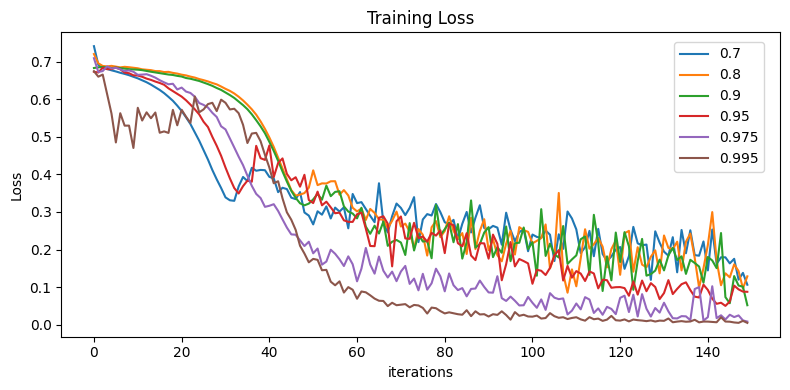

In [79]:
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Training Loss')
ax.set_xlabel('iterations')
ax.set_ylabel('Loss')
for i in range (len(Mat['Propotions'])):
  ax.plot(Mat['Train_loss'][i], label = f"{Mat['Propotions'][i]}")
fig.legend(loc='upper right', bbox_to_anchor=(0.97, 0.9))
fig.tight_layout()
fig.savefig("/content/drive/MyDrive/data1/Imbalance/Training_Loss.jpg",dpi=100)
plt.show()

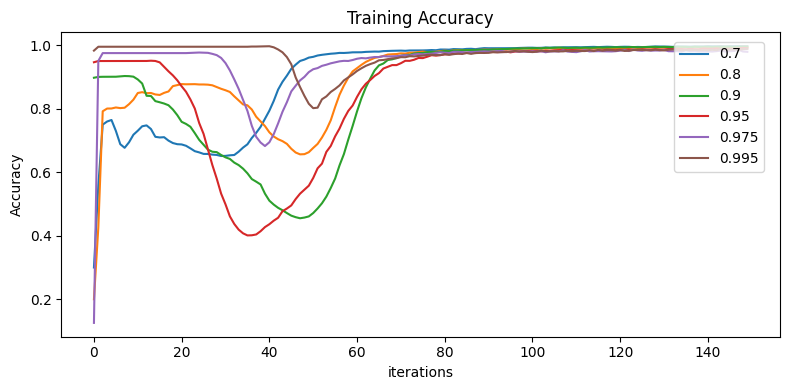

In [78]:
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Training Accuracy')
ax.set_xlabel('iterations')
ax.set_ylabel('Accuracy')
for i in range (len(Mat['Propotions'])):
  ax.plot(Mat['Train_acc'][i], label = f"{Mat['Propotions'][i]}")
fig.legend(loc='upper right', bbox_to_anchor=(0.97, 0.9))
fig.tight_layout()
fig.savefig("/content/drive/MyDrive/data1/Imbalance/Training_Accuracy.jpg",dpi=100)
plt.show()

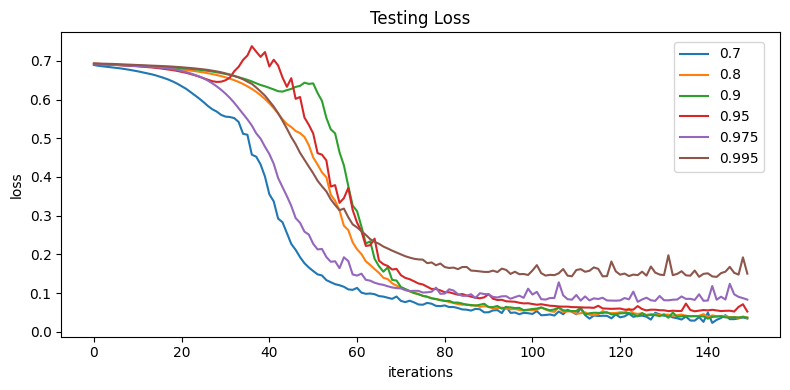

In [77]:
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Testing Loss')
ax.set_xlabel('iterations')
ax.set_ylabel('loss')
for i in range (len(Mat['Propotions'])):
  ax.plot(Mat['Test_loss'][i], label = f"{Mat['Propotions'][i]}")
fig.legend(loc='upper right', bbox_to_anchor=(0.97, 0.9))
fig.tight_layout()
fig.savefig("/content/drive/MyDrive/data1/Imbalance/Testing_Loss.jpg",dpi=100)
plt.show()

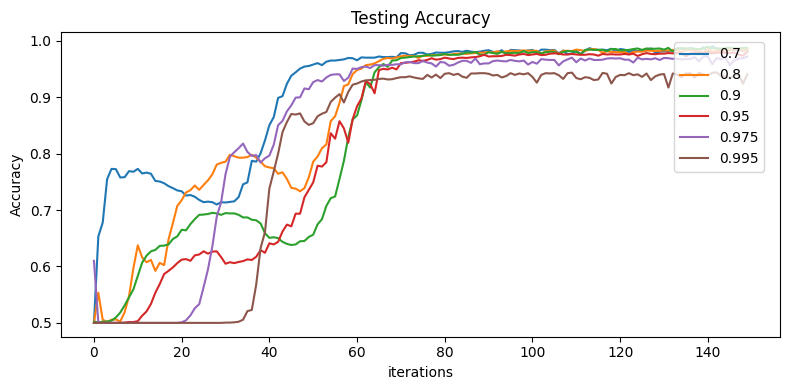

In [80]:
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Testing Accuracy')
ax.set_xlabel('iterations')
ax.set_ylabel('Accuracy')
for i in range (len(Mat['Propotions'])):
  ax.plot(Mat['Test_acc'][i], label = f"{Mat['Propotions'][i]}")
fig.legend(loc='upper right', bbox_to_anchor=(0.97, 0.9))
fig.tight_layout()
fig.savefig("/content/drive/MyDrive/data1/Imbalance/Testing_Accuracy.jpg",dpi=100)
plt.show()

In [81]:
Acc = []
for i in range (len(Mat['Propotions'])):
  Acc.append(Mat['Test_acc'][i][-1])

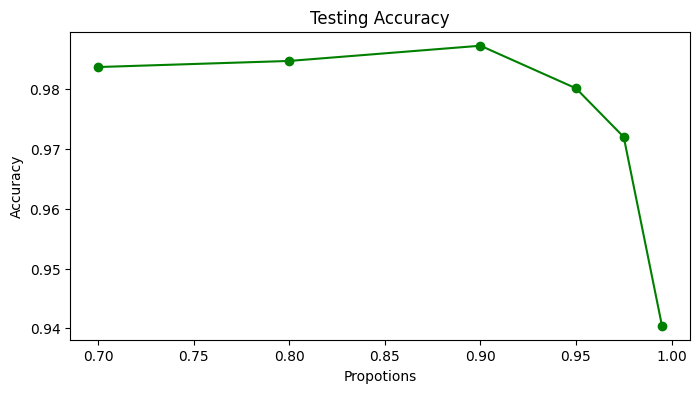

In [85]:
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Testing Accuracy')
ax.set_xlabel('Propotions')
ax.set_ylabel('Accuracy')
plt.plot(Mat['Propotions'],Acc,'go-')
fig.savefig("/content/drive/MyDrive/data1/Imbalance/Testing_Curve.jpg",dpi=100)
plt.show()

## Experiment with different Noise variance [0.1, 0.2, 0.5, 1, 2, 5]

In [86]:
Mat = {'Noise':[],'Train_loss':[],'Train_acc':[],'Test_loss':[],'Test_acc':[]}
Noise =[0.1,0.2,0.5,1,2,5]
Mat['Noise'] = Noise
for n in Noise:
  args = {'bs':100, 'lr':1e-3, 'n_epochs':150, 'device':'cuda:0'}

  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
  test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)
  train_dataset, meta_dataset, test_dataset = get_imbalanced_datasets(train_dataset, test_dataset)

  # Add Gaussian noise to the images
  noise_factor = n
  noisy_data = []
  for image, label in train_dataset:
      noisy_image = image + noise_factor * torch.randn(image.shape)
      noisy_data.append((noisy_image, label))
  train_dataset = torch.utils.data.TensorDataset(torch.stack([item[0] for item in noisy_data]),
                                                torch.tensor([item[1] for item in noisy_data]))

  # Add Gaussian noise to the images
  noise_factor = n
  noisy_data = []
  for image, label in test_dataset:
      noisy_image = image + noise_factor * torch.randn(image.shape)
      noisy_data.append((noisy_image, label))
  test_dataset = torch.utils.data.TensorDataset(torch.stack([item[0] for item in noisy_data]),
                                                torch.tensor([item[1] for item in noisy_data]))

  train_loader = DataLoader(train_dataset, batch_size=args['bs'], shuffle=True, num_workers=2, pin_memory=True)
  test_loader =  DataLoader(test_dataset, batch_size=args['bs'], shuffle=False, num_workers=2, pin_memory=True)
  meta_loader = DataLoader(meta_dataset, batch_size=args['bs'], shuffle=True, pin_memory=True)
  meta_loader = itertools.cycle(meta_loader)

  model = LeNet5().to(args['device'])
  opt = optim.SGD(model.parameters(), lr=args['lr'])
  criterion = nn.BCEWithLogitsLoss().to(args['device'])

  start_time, end_time = torch.cuda.Event(enable_timing=True),\
                          torch.cuda.Event(enable_timing=True)
  start_time.record() 
  
  Train_loss_l2r = []
  Train_acc_l2r = []
  Test_loss_l2r = []
  Test_acc_l2r = []
  for ep in tqdm(range(1, args['n_epochs']+1)):
      model.train()
      train_loss, train_acc = 0, 0
      for _, (inputs, labels) in enumerate(train_loader):
          inputs, labels = inputs.to(device=args['device'], non_blocking=True),\
                              labels.to(device=args['device'], non_blocking=True)
          
          opt.zero_grad()
          with higher.innerloop_ctx(model, opt) as (meta_model, meta_opt):
              # 1. Update meta model on training data
              meta_train_outputs = meta_model(inputs)
              criterion.reduction = 'none'
              meta_train_loss = criterion(meta_train_outputs, labels.type_as(outputs))
              eps = torch.zeros(meta_train_loss.size(), requires_grad=True, device=args['device'])
              meta_train_loss = torch.sum(eps * meta_train_loss)
              meta_opt.step(meta_train_loss)

              # 2. Compute grads of eps on meta validation data
              meta_inputs, meta_labels =  next(meta_loader)
              meta_inputs, meta_labels = meta_inputs.to(device=args['device'], non_blocking=True),\
                              meta_labels.to(device=args['device'], non_blocking=True)

              meta_val_outputs = meta_model(meta_inputs)
              criterion.reduction = 'mean'
              meta_val_loss = criterion(meta_val_outputs, meta_labels.type_as(outputs))
              eps_grads = torch.autograd.grad(meta_val_loss, eps)[0].detach()

          # 3. Compute weights for current training batch
          w_tilde = torch.clamp(-eps_grads, min=0)
          l1_norm = torch.sum(w_tilde)
          if l1_norm != 0:
              w = w_tilde / l1_norm
          else:
              w = w_tilde

          # 4. Train model on weighted batch
          outputs = model(inputs)
          criterion.reduction = 'none'
          minibatch_loss = criterion(outputs, labels.type_as(outputs))
          minibatch_loss = torch.sum(w * minibatch_loss)
          minibatch_loss.backward()
          opt.step()

          # keep track of epoch loss/accuracy
          train_loss += minibatch_loss.item()*outputs.shape[0]
          pred_labels = (F.sigmoid(outputs) > 0.5).int()
          train_acc += torch.sum(torch.eq(pred_labels, labels)).item()

      # inference after epoch
      with torch.no_grad():
          train_loss, train_acc = train_loss/len(train_dataset), train_acc/len(train_dataset)       
          test_loss, (test_acc, test_per_class_acc) = get_loss_n_accuracy(model, criterion, test_loader, args)                                  
          Train_loss_l2r.append(train_loss)
          Train_acc_l2r.append(train_acc)
          Test_loss_l2r.append(test_loss)
          Test_acc_l2r.append(test_acc)

  Mat['Train_loss'].append(Train_loss_l2r)
  Mat['Train_acc'].append(Train_acc_l2r)
  Mat['Test_loss'].append(Test_loss_l2r)
  Mat['Test_acc'].append(Test_acc_l2r)

  print(f'|Train/Test Loss: {train_loss:.3f} / {test_loss:.3f}|', end='--')
  print(f'|Train/Test Acc: {train_acc:.3f} / {test_acc:.3f}|') 
  
 
  end_time.record()
  torch.cuda.synchronize()
  time_elapsed_secs = start_time.elapsed_time(end_time)/10**3
  time_elapsed_mins = time_elapsed_secs/60
  print(f'Training took {time_elapsed_secs:.2f} seconds / {time_elapsed_mins:.2f} minutes')

  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.131 / 0.027|--|Train/Test Acc: 0.995 / 0.988|
Training took 288.40 seconds / 4.81 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.217 / 0.041|--|Train/Test Acc: 0.989 / 0.985|
Training took 285.24 seconds / 4.75 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.264 / 0.059|--|Train/Test Acc: 0.981 / 0.978|
Training took 291.44 seconds / 4.86 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.181 / 0.079|--|Train/Test Acc: 0.976 / 0.971|
Training took 311.18 seconds / 5.19 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.171 / 0.616|--|Train/Test Acc: 0.833 / 0.814|
Training took 301.88 seconds / 5.03 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.386 / 1.032|--|Train/Test Acc: 0.751 / 0.696|
Training took 303.06 seconds / 5.05 minutes


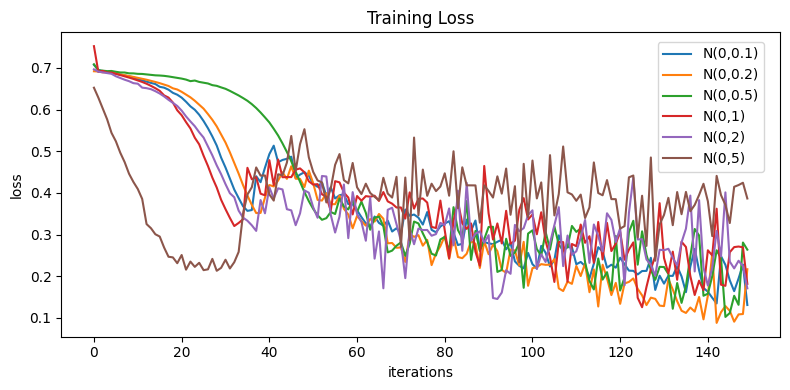

In [87]:
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Training Loss')
ax.set_xlabel('iterations')
ax.set_ylabel('loss')
for i in range (len(Mat['Noise'])):
  ax.plot(Mat['Train_loss'][i], label = f"N(0,{Mat['Noise'][i]})")
fig.legend(loc='upper right', bbox_to_anchor=(0.97, 0.9))
fig.tight_layout()
fig.savefig("/content/drive/MyDrive/data1/Training_Loss.jpg",dpi=100)
plt.show()

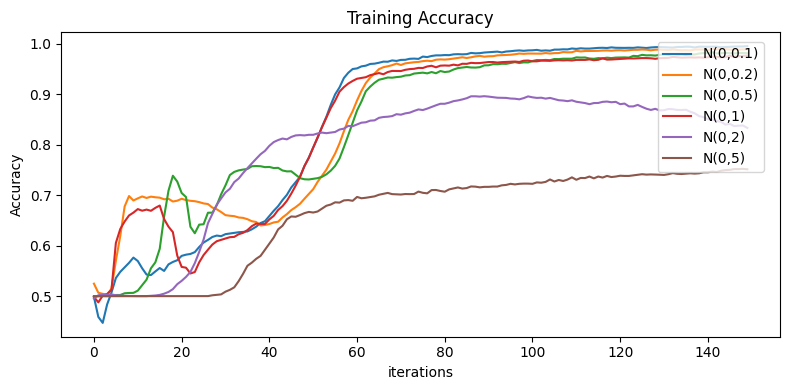

In [88]:
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Training Accuracy')
ax.set_xlabel('iterations')
ax.set_ylabel('Accuracy')
for i in range (len(Mat['Noise'])):
  ax.plot(Mat['Train_acc'][i], label = f"N(0,{Mat['Noise'][i]})")
fig.legend(loc='upper right', bbox_to_anchor=(0.97, 0.9))
fig.tight_layout()
fig.savefig("/content/drive/MyDrive/data1/Training_Accuracy.jpg",dpi=100)
plt.show()

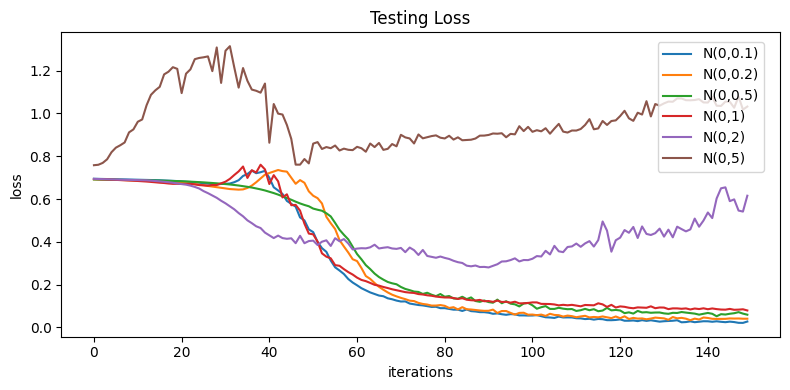

In [89]:
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Testing Loss')
ax.set_xlabel('iterations')
ax.set_ylabel('loss')
for i in range (len(Mat['Noise'])):
  ax.plot(Mat['Test_loss'][i], label = f"N(0,{Mat['Noise'][i]})")
fig.legend(loc='upper right', bbox_to_anchor=(0.97, 0.9))
fig.tight_layout()
fig.savefig("/content/drive/MyDrive/data1/Testing_Loss.jpg",dpi=100)
plt.show()

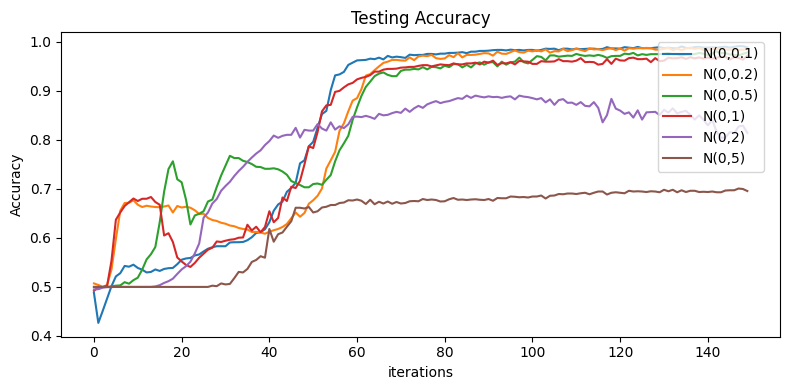

In [90]:
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Testing Accuracy')
ax.set_xlabel('iterations')
ax.set_ylabel('Accuracy')
for i in range (len(Mat['Noise'])):
  ax.plot(Mat['Test_acc'][i], label = f"N(0,{Mat['Noise'][i]})")
fig.legend(loc='upper right', bbox_to_anchor=(0.97, 0.9))
fig.tight_layout()
fig.savefig("/content/drive/MyDrive/data1/Testing_Accuracy.jpg",dpi=100)
plt.show()

In [92]:
Mat['Noise']

[0.1, 0.2, 0.5, 1, 2, 5]

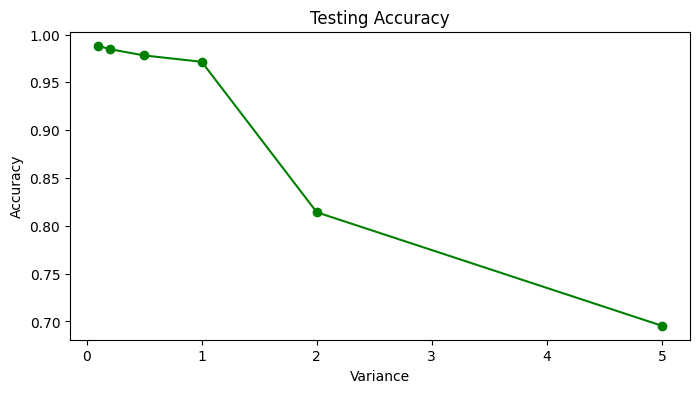

In [91]:
Acc = []
for i in range (len(Mat['Noise'])):
  Acc.append(Mat['Test_acc'][i][-1])
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Testing Accuracy')
ax.set_xlabel('Variance')
ax.set_ylabel('Accuracy')
plt.plot(Mat['Noise'],Acc,'go-')
fig.savefig("/content/drive/MyDrive/data1/Testing_Curve.jpg",dpi=100)
plt.show()

## Experiment on different size of the clean validation set [15, 30, 50, 100, 200, 500]

In [93]:
Mat = {'Propotions':[],'Train_loss':[],'Train_acc':[],'Test_loss':[],'Test_acc':[]}
Propotions =[15, 30, 50, 100, 200, 500]
Mat['Propotions'] = Propotions
for pro in Propotions:
  args = {'bs':100, 'lr':1e-3, 'n_epochs':150, 'device':'cuda:0'}

  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
  test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)
  train_dataset, meta_dataset, test_dataset = get_imbalanced_datasets(train_dataset, test_dataset, meta_size=pro)

  train_loader = DataLoader(train_dataset, batch_size=args['bs'], shuffle=True, num_workers=2, pin_memory=True)
  test_loader =  DataLoader(test_dataset, batch_size=args['bs'], shuffle=False, num_workers=2, pin_memory=True)
  meta_loader = DataLoader(meta_dataset, batch_size=args['bs'], shuffle=True, pin_memory=True)
  meta_loader = itertools.cycle(meta_loader)

  model = LeNet5().to(args['device'])
  opt = optim.SGD(model.parameters(), lr=args['lr'])
  criterion = nn.BCEWithLogitsLoss().to(args['device'])

  start_time, end_time = torch.cuda.Event(enable_timing=True),\
                          torch.cuda.Event(enable_timing=True)
  start_time.record() 
  
  Train_loss_l2r = []
  Train_acc_l2r = []
  Test_loss_l2r = []
  Test_acc_l2r = []
  for ep in tqdm(range(1, args['n_epochs']+1)):
      model.train()
      train_loss, train_acc = 0, 0
      for _, (inputs, labels) in enumerate(train_loader):
          inputs, labels = inputs.to(device=args['device'], non_blocking=True),\
                              labels.to(device=args['device'], non_blocking=True)
          
          opt.zero_grad()
          with higher.innerloop_ctx(model, opt) as (meta_model, meta_opt):
              # 1. Update meta model on training data
              meta_train_outputs = meta_model(inputs)
              criterion.reduction = 'none'
              meta_train_loss = criterion(meta_train_outputs, labels.type_as(outputs))
              eps = torch.zeros(meta_train_loss.size(), requires_grad=True, device=args['device'])
              meta_train_loss = torch.sum(eps * meta_train_loss)
              meta_opt.step(meta_train_loss)

              # 2. Compute grads of eps on meta validation data
              meta_inputs, meta_labels =  next(meta_loader)
              meta_inputs, meta_labels = meta_inputs.to(device=args['device'], non_blocking=True),\
                              meta_labels.to(device=args['device'], non_blocking=True)

              meta_val_outputs = meta_model(meta_inputs)
              criterion.reduction = 'mean'
              meta_val_loss = criterion(meta_val_outputs, meta_labels.type_as(outputs))
              eps_grads = torch.autograd.grad(meta_val_loss, eps)[0].detach()

          # 3. Compute weights for current training batch
          w_tilde = torch.clamp(-eps_grads, min=0)
          l1_norm = torch.sum(w_tilde)
          if l1_norm != 0:
              w = w_tilde / l1_norm
          else:
              w = w_tilde

          # 4. Train model on weighted batch
          outputs = model(inputs)
          criterion.reduction = 'none'
          minibatch_loss = criterion(outputs, labels.type_as(outputs))
          minibatch_loss = torch.sum(w * minibatch_loss)
          minibatch_loss.backward()
          opt.step()

          # keep track of epoch loss/accuracy
          train_loss += minibatch_loss.item()*outputs.shape[0]
          pred_labels = (F.sigmoid(outputs) > 0.5).int()
          train_acc += torch.sum(torch.eq(pred_labels, labels)).item()

      # inference after epoch
      with torch.no_grad():
          train_loss, train_acc = train_loss/len(train_dataset), train_acc/len(train_dataset)       
          test_loss, (test_acc, test_per_class_acc) = get_loss_n_accuracy(model, criterion, test_loader, args)                                  
          Train_loss_l2r.append(train_loss)
          Train_acc_l2r.append(train_acc)
          Test_loss_l2r.append(test_loss)
          Test_acc_l2r.append(test_acc)

  Mat['Train_loss'].append(Train_loss_l2r)
  Mat['Train_acc'].append(Train_acc_l2r)
  Mat['Test_loss'].append(Test_loss_l2r)
  Mat['Test_acc'].append(Test_acc_l2r)

  print(f'|Train/Test Loss: {train_loss:.3f} / {test_loss:.3f}|', end='--')
  print(f'|Train/Test Acc: {train_acc:.3f} / {test_acc:.3f}|') 
  
 
  end_time.record()
  torch.cuda.synchronize()
  time_elapsed_secs = start_time.elapsed_time(end_time)/10**3
  time_elapsed_mins = time_elapsed_secs/60
  print(f'Training took {time_elapsed_secs:.2f} seconds / {time_elapsed_mins:.2f} minutes')

  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.066 / 0.044|--|Train/Test Acc: 0.989 / 0.983|
Training took 563.15 seconds / 9.39 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.110 / 0.035|--|Train/Test Acc: 0.988 / 0.983|
Training took 554.29 seconds / 9.24 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.147 / 0.047|--|Train/Test Acc: 0.984 / 0.979|
Training took 569.73 seconds / 9.50 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.190 / 0.026|--|Train/Test Acc: 0.993 / 0.989|
Training took 569.37 seconds / 9.49 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.249 / 0.034|--|Train/Test Acc: 0.992 / 0.992|
Training took 574.72 seconds / 9.58 minutes


  0%|          | 0/150 [00:00<?, ?it/s]

|Train/Test Loss: 0.186 / 0.027|--|Train/Test Acc: 0.996 / 0.992|
Training took 586.45 seconds / 9.77 minutes


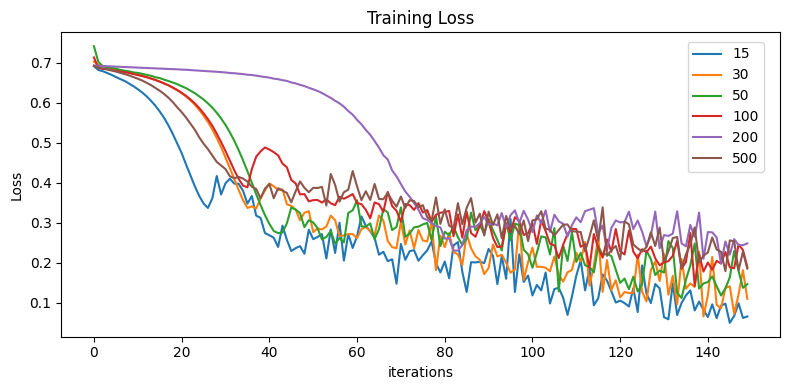

In [95]:
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Training Loss')
ax.set_xlabel('iterations')
ax.set_ylabel('Loss')
for i in range (len(Mat['Propotions'])):
  ax.plot(Mat['Train_loss'][i], label = f"{Mat['Propotions'][i]}")
fig.legend(loc='upper right', bbox_to_anchor=(0.97, 0.9))
fig.tight_layout()
fig.savefig("/content/drive/MyDrive/data1/Meta_Size/Training_Loss.jpg",dpi=100)
plt.show()

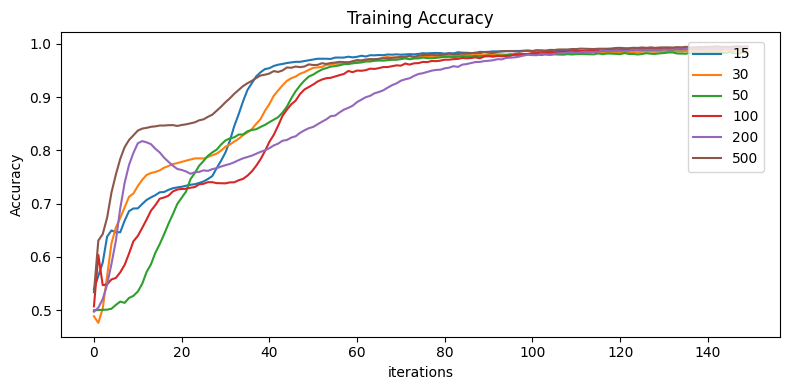

In [96]:
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Training Accuracy')
ax.set_xlabel('iterations')
ax.set_ylabel('Accuracy')
for i in range (len(Mat['Propotions'])):
  ax.plot(Mat['Train_acc'][i], label = f"{Mat['Propotions'][i]}")
fig.legend(loc='upper right', bbox_to_anchor=(0.97, 0.9))
fig.tight_layout()
fig.savefig("/content/drive/MyDrive/data1/Meta_Size/Training_Accuracy.jpg",dpi=100)
plt.show()

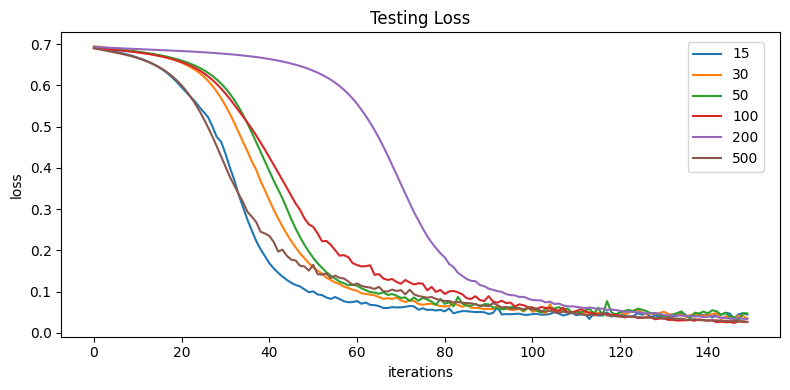

In [99]:
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Testing Loss')
ax.set_xlabel('iterations')
ax.set_ylabel('loss')
for i in range (len(Mat['Propotions'])):
  ax.plot(Mat['Test_loss'][i], label = f"{Mat['Propotions'][i]}")
fig.legend(loc='upper right', bbox_to_anchor=(0.97, 0.9))
fig.tight_layout()
fig.savefig("/content/drive/MyDrive/data1/Meta_Size/Testing_Loss.jpg",dpi=100)
plt.show()

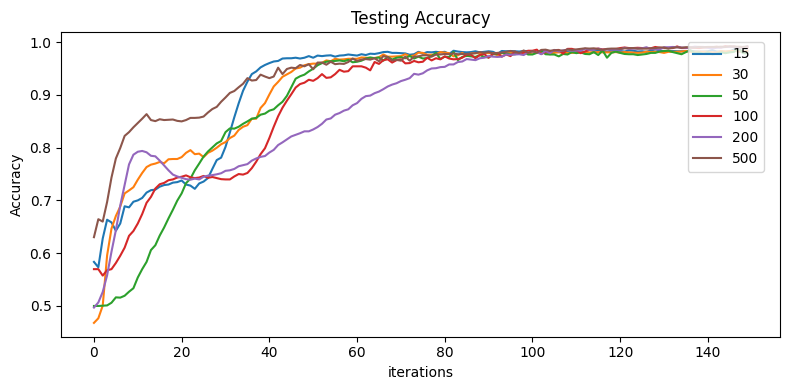

In [97]:
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Testing Accuracy')
ax.set_xlabel('iterations')
ax.set_ylabel('Accuracy')
for i in range (len(Mat['Propotions'])):
  ax.plot(Mat['Test_acc'][i], label = f"{Mat['Propotions'][i]}")
fig.legend(loc='upper right', bbox_to_anchor=(0.97, 0.9))
fig.tight_layout()
fig.savefig("/content/drive/MyDrive/data1/Meta_Size/Testing_Accuracy.jpg",dpi=100)
plt.show()

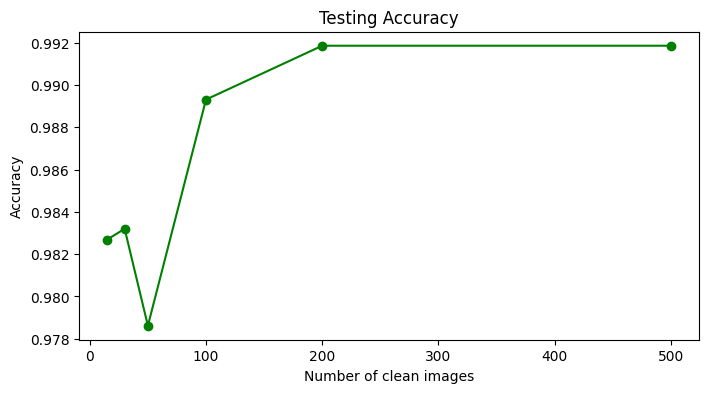

In [98]:
Acc = []
for i in range (len(Mat['Propotions'])):
  Acc.append(Mat['Test_acc'][i][-1])
fig, ax = plt.subplots(ncols=1, figsize = (8,4))
ax.set_title('Testing Accuracy')
ax.set_xlabel('Number of clean images')
ax.set_ylabel('Accuracy')
plt.plot(Mat['Propotions'],Acc,'go-')
fig.savefig("/content/drive/MyDrive/data1/Meta_Size/Testing_Curve.jpg",dpi=100)
plt.show()